<a href="https://colab.research.google.com/github/coryroyce/Facilities_ML_Project/blob/main/Notebooks/Facilities_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facilities Machine Learning Project

Author: [coryroyce](https://github.com/coryroyce)

Date updated: 3/31/2021

# Overview

Create a simple machine learning model to predict when a Work Order will likely become past due.

# Load Python Packages

Install Needed Packages

In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 65kB/s 


Import required packages

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Load Data

Load in the sample Work Order data from a csv file. Note, this can be downloaed locally from [GitHub](https://github.com/coryroyce/Facilities_ML_Project/tree/main/Data) if needed.

In [3]:
# Set the url of where the csv data can be downloaded from
url = 'https://raw.githubusercontent.com/coryroyce/Facilities_ML_Project/main/Data/Maintenace_Past_Due_Sample_Data.csv'
# Load the csv data into a Pandas DataFrame to easily work with the data in python
df = pd.read_csv(url)

# Make sure the data is the correct type
new_dtypes = {'Department' : 'category', 'Name': 'category', 'Estimated_Labor_Hours' : 'int64',
              'Frequency' : 'category', 'Past_Due' : 'int64'}
df = df.astype(new_dtypes)

Display the first few rows of data to verify eveything loaded correctly.

In [4]:
df.head(5)

,Department,Name,Estimated_Labor_Hours,Frequency,Past_Due
0,Electrical,Peter,10,90 Days,1
1,Mechanical,Sam,12,90 Days,0
2,Electrical,Sam,4,30 Days,0
3,Plumbing,Sam,16,90 Days,0
4,HVAC,Steven,10,360 Days,1


Data Details:

This sample data is meant to mirror the types of data that can easily be retrieved from a Computerized Maintenance Management System (CMMS), where each row is a historical Work Order that has been completed previously.

* **Department** = The department name of the type of work being performed on a given Work Order/Maintenance Task. (e.g. Electrical, Mechanical, etc)
* **Name** = Name of the technician who completed the work. (Randomly generated fictional names for this sample data)
* **Estimated Labor Hours** = The approximate number of labor hours a given Work Order/Task is expected to take.
* **Frequency** = The frequency interval for when these Work Orders/Task will have to be completed again. (e.g. a 90 Day task would mean the task would be done ~4 times per year (365 Days / 90 Days)).
* **Past Due** = The label for if a particular work order was past due. (e.g. 1 = Work Order was Past Due, and 0 = Work Order completed on time.)





# Create a Machine Learning Model

Now that the data is loaded and ready to be processed, we can begin creating a Machine Learning Model. If you’re just getting started with ML, it’s worth noting that our model is a supervised classification model with numerical and categorical feature data. [Catboost](https://catboost.ai/) is a ML framework that serves as a good fit in terms of simplicity and good performance without much hyperparameter tuning. To better understand how these ML models work in greater detail, a good place to begin is [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course).

## Split Train and Test Data

Divide the data into train and test sets so that we can see how accurate the model is on data that it has never seen before (test data).

In [5]:
# Separate the features/inputs from the labels/outputs
X = df.copy()
y = X.pop('Past_Due')

# Split the data into train and test data with 20% of the data to test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Create ML Model

To create the model we choose what type of model we want to use and in this case we are using Catboost since it works well with categorical variables like Department, and Name in our specific case.

In [6]:
# Select the ML Model type
model = CatBoostClassifier()

# Fit the model to the training data
model.fit(X_train, y_train,
          cat_features=['Department', 'Name', 'Frequency'],
          eval_set=(X_test, y_test))

# Clear output for this cell
from IPython.display import clear_output
clear_output()

# Display breif overview of Model Information
print(f'Model Trained!')
print(f'Best Iteration: {model.best_iteration_}')
print(f'Best Loss Info: {model.best_score_}')

Model Trained!
Best Iteration: 342
Best Loss Info: {'learn': {'Logloss': 0.04379990158969453}, 'validation': {'Logloss': 0.22202244616464215}}


## Review Model Metrics

Review the high level metrics of the model to understand how accurate it actually is.

In [7]:
# Store the predicted scores from the test dataset
preds_test = model.predict(X_test)

# Print the accuracy of the test predictions
print(f'Model Accuracy on test data: {metrics.accuracy_score(y_test, preds_test)*100}%')

Model Accuracy on test data: 89.0%


This ML model is able to predict if a Work Order will likely become past due with a 90% accuracy.

Show the predicted vs actuals in a confusion matrix. This plot shows us the number of predictions that were right or wrong based on the test data the ML model has never seen before.

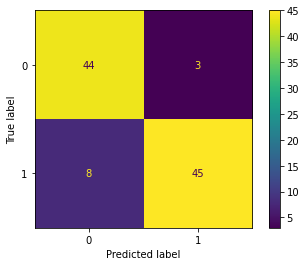

In [8]:
# Use Sklearn's confusion matrix functionality on our test data
metrics.plot_confusion_matrix(estimator = model,
                              X = X_test, 
                              y_true = y_test)

This plot indicates that the model is actually pretty accurate since the upper left (Actual data was 0 and the model correctly predicted 0) and the lower right (Actual data was 1 and the model correctly predicted 1) have high values.

## Predict on New Values

Use the Machine learning model to predict individual samples.

In [9]:
# Manually input any combination of features to get a prediction (Note: Order of data has to match the column orders)
sample = ['Electrical', 'Chris', 4,'90 Days']

# Send the sample to the model for prediction
sample_prediction = model.predict(sample)

# Display prediction
print(f'Current Sample is predicted as {sample_prediction} \n(Note: 1 = Past Due, 0 = On Time)')

Current Sample is predicted as 1 
(Note: 1 = Past Due, 0 = On Time)


This is now a working machine learning model that is trained on historical work order data to predict if a given work order is likely to become past due. This could be a decent place to stop knowing the model is correct/accurate ~90% of the time, but we can actually gain a lot of insight if we apply explainable AI.

# Explainable AI

Taking this ML project one step further we an get explanation for each of the inputs as to why the model made a certian prediction and can help provide much more insite into the patterns in the data with summary level explanations aswell.

Instal the Explainable AI package [SHAP](https://shap.readthedocs.io/en/latest/)

In [10]:
!pip install shap
import shap

# Clear output for this cell
from IPython.display import clear_output
clear_output()

Use the [SHAP](https://shap.readthedocs.io/en/latest/index.html) package to generate explanations of our data.

In [11]:
# Use the Tree Explainer in SHAP since Catboost is a tree based model
explainer = shap.TreeExplainer(model = model)

# Generate the SHAP Values for the traing data
shap_values = explainer.shap_values(X_train)

## Individual Prediction Explanation

Use the SHAP Values to explain the breakdown of how much each feature influenced an individual prediction.

In [12]:
shap.initjs()

# Visualize the prediction explanation in a Force Plot for the 3rd example (index = 2) in our training data.
shap.force_plot(explainer.expected_value, shap_values[2,:], X_train.iloc[2,:])

Visualize this same explaination of the 3rd sample with a waterfall plot.

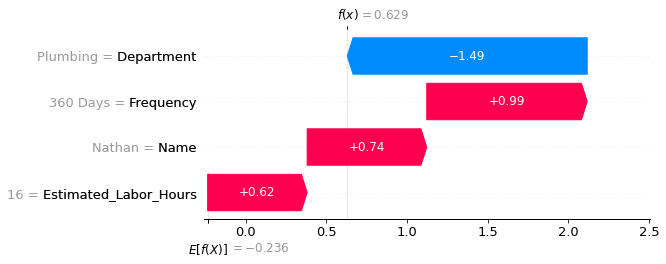

In [13]:
shap.waterfall_plot(shap_values = explainer(X_train)[2])

In both of the explanations above, we see that the final output is above the base value/expected value so this particular Work Order would be predicted as likely to become Past Due.

We can also view the detailed explanation for every individual data with an interactive chart. Hover over to see details of individual Work Order explanations. 

In [14]:
shap.initjs()
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

## Summary Explanation

Create a summary plot that shows how much influence each feature has on the over all prediction. Note: Categorical columns are gray since the don't have a numeric value that is Higher (red) or Lower (blue).

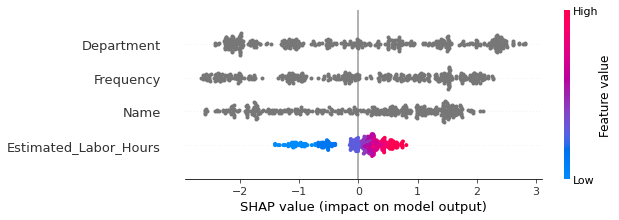

In [15]:
shap.summary_plot(shap_values = shap_values, features = X_train)

This same data can also be viewed in a simple bar chart.

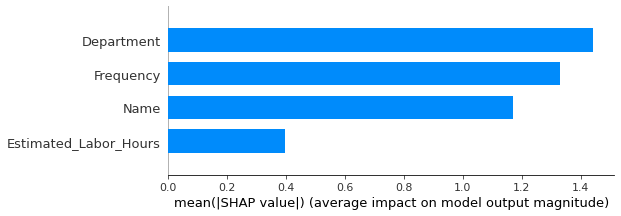

In [16]:
shap.summary_plot(shap_values = shap_values, features = X_train, plot_type = 'bar')

## Feature Details

Each feature can be drilled down into to find patterns in the original data that would be very hard to find with non-machine learning methods. 

With the below depandance plots, if the SHAP value is above 0 (top half of the graph) then that means a stronger likelihood of a Work Order being passed due. Likwaise a value below 0 means it is likely to be on time. One last note is that magnitude matters so a score of 3 is strongly tied to past due work orders whereas a value of 1 would only slightly push the model to a prediction of past due.


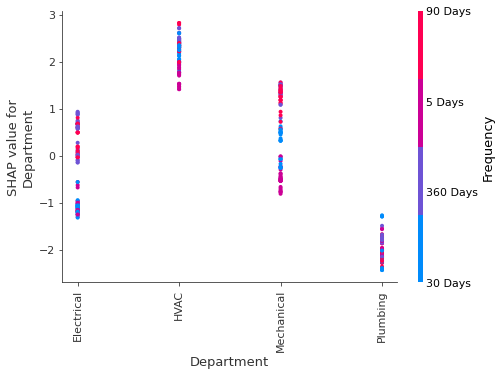

In [17]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(ind = 'Department', shap_values = shap_values, features = X_train)

Remove the seconday coloring and compare the dependance plot for each feature/input of our dataset.

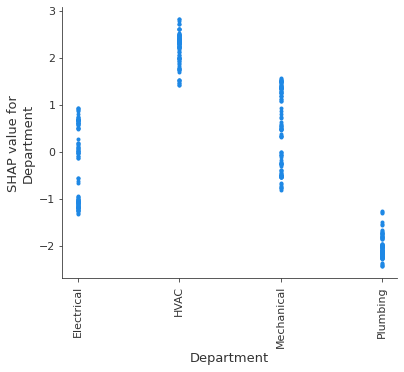

In [18]:
# Create a SHAP dependence plot for the Department
shap.dependence_plot(ind = 'Department', shap_values = shap_values, features = X_train, interaction_index=None)

Department notes: The HVAC department has a high correlation with past due Work Orders. Where as the Plumbing department seems to complete Work Order on time.

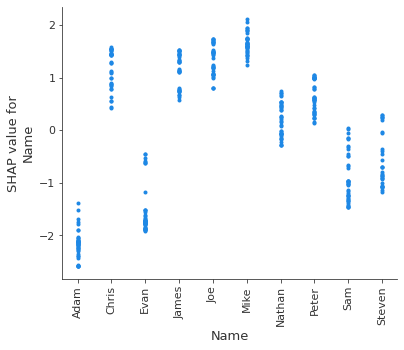

In [19]:
# Create a SHAP dependence plot for the Name
shap.dependence_plot(ind = 'Name', shap_values = shap_values, features = X_train, interaction_index=None)

Name notes: Adam, Evan, Sam and Steven are more often completing work on time. Where as Chris, James, Joe, Mike and Peter increase the models chance of predictinf that a Work Order will become past due.

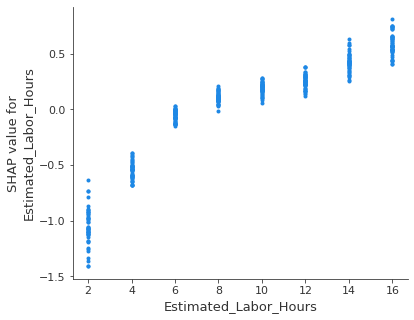

In [21]:
# Create a SHAP dependence plot for the Estimated Labor Hours
shap.dependence_plot(ind = 'Estimated_Labor_Hours', shap_values = shap_values, features = X_train, interaction_index=None)

Estimated Labor Hours notes: The trend here is pretty clear. The longer a task is estimated to take the more likely it is to become past and Work Orders with an estimated 16 hours of labor are much more likely to become past due, than ones with only 8 hours of estimated labor.

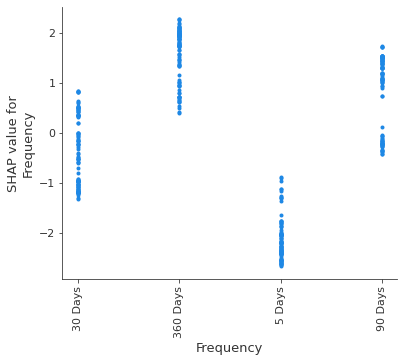

In [22]:
# Create a SHAP dependence plot for the Frequency
shap.dependence_plot(ind = 'Frequency', shap_values = shap_values, features = X_train, interaction_index=None)

Frequency notes: The Work Oders that are done in a 5 day Frequency are often completed on time where as the anual/360 Day Work Order increase the likelyhood of our ML model predicting past due.

In [20]:
df.columns.tolist()

['Department', 'Name', 'Estimated_Labor_Hours', 'Frequency', 'Past_Due']

# Summary

This notebook provides an example machine learning project within the Facilities Operations and covers these main phases:
* Defining an initial business problem
* Determining what repeatable process provides usable data
* Creating a working machine learning model
* Generating detailed explanations

Potential Future Work:
* Turn this problem into a regression problem that predicts "How many days late" a work order will go. This would be easy to calculate from a real world data set since it would be the difference between the Target Due Date and the Actual Complete Date of historical records. The added value is that now you can prioritize based on severity of past due rather than a simple "yes/no" label.
* Improve the accuracy through hyperparameter tuning.  
